# DMP

Control policy:
- (traditional) state-centered representation $\mathbf{u}_t = \pi(\mathbf{s}_t)$
  - algorihms are hard to apply
- Trajectory-centered representation: control policy reduced to a desired trajectory $[\mathbf{x}_d(t), \dot{\mathbf{x}}_d(t)]$:
$$\mathbf{u}_t = K_x (\mathbf{x}_d(t) - \mathbf{x}) + K_{\dot{x}}(\dot{\mathbf{x}}_d(t) - \dot{\mathbf{x}})$$
  - Requires a (linear) feedback controller
  - Reduces complexity of the learning problem
  - Only valid around vicinity of the desired trajectory, not very flexible
  - Hard to adapt the pre-planned trajectories (time and space)

Dynamical system representation:
- Define behavior by non-linear dynamical systems $\dot{\mathbf{x}}_d = f(\mathbf{x}, \theta) $
- $[\mathbf{x}_d(t), \dot{\mathbf{x}}_d(t)]$ are converted to motor commands by a (inverse dynamics) controller
- Cancels non-linearities due to gravity or inertial forces

A DMP defines a single movement, kinematic state (q, $\dot{q}$, $\ddot{q}$), or in task space.
- Discrete DMP: The base system is a point attractor
- Rhythmic DMP: The base system is a limit cycle


# Discrete DMP
A discrete DMP is a combination of a (2nd order) basic point attractor dynamics (base system) and a (nonlinear) 'force' dynamics: A damped spring attached to a goal position $g$, perturbed by a non-linear acceleration $f$.

## Point attractor dynamics:
\begin{equation}
\ddot{x} = K(g - x) - D(\dot{x}) \\
\end{equation}
where $x$ is the (joint) position, $\dot{x}$ (joint) velocity, $\ddot{x}$ (joint) acceleration, $g$ the goal, $K$ the spring constant, and $D$ the damping constant.

- *For some $K$ and $D$ and $f=0$, $g$ is a unique point attractor *

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def attractor_dynamics(x, dx, g, K, D, T=20):
    xs = np.zeros(T)
    dxs = np.zeros(T)
    ddxs = np.zeros(T)
    xs[0] = x
    dxs[0] = dx
    for t in range(T-1):
        ddxs[t] = K*(g - xs[t]) - D*(dxs[t])
        dxs[t+1] = dxs[t] + ddxs[t]
        xs[t+1] = xs[t] + dxs[t]
    return xs, dxs, ddxs

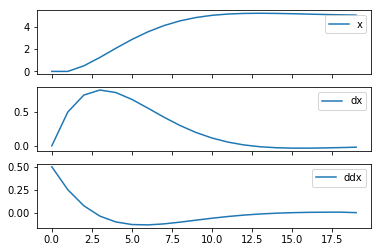

In [56]:
K = 0.1
D = 0.5
x = 0
dx = 0
g = 5

xs, dxs, ddxs = attractor_dynamics(x, dx, g, K, D)

fix, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(xs, label='x')
axs[0].legend()
axs[1].plot(dxs, label='dx')
axs[1].legend()
axs[2].plot(ddxs, label='ddx')
axs[2].legend()
plt.show()

## Force term dynamics
### canonical system
- Avoid explicit dependency on time for modelling $f$ with a **canonical system**.
- Models the phase/progress of the movement (1st order "leaky integrator")
$$\dot{s} = - \alpha s$$
$s$ is initially set to 1, in the limit $s\rightarrow0$

In [57]:
def canonical_dynamics(alpha, s0=1, T=20):
    ss = np.zeros(T)
    dss = np.zeros(T)
    ss[0] = s0
    for t in range(T-1):
        dss[t] = -alpha*ss[t]
        ss[t+1] = ss[t] + dss[t]
    return ss, dss

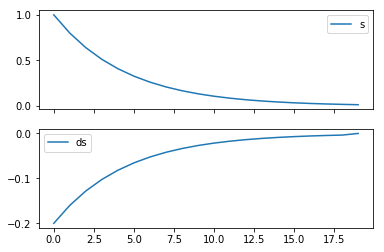

In [58]:
alpha = 0.2
ss, dss = canonical_dynamics(alpha)

fix, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ss, label='s')
axs[0].legend()
axs[1].plot(dss, label='ds')
axs[1].legend()
plt.show()

### Gaussian basis functions
Model $f$ with:
$$f(s,g) = \frac{\sum_{i=1}^N \psi_i(s) w_i}{\sum_{i=1}^N \psi_i(s)} s (g - x_0)$$
where $y_0$ is the initial position of the system, $w_i$ is a weighting for a given basis function $\psi_i$: 
$$\psi_i(s) = \exp(-h_i (s-c_i)^2)$$

### Diminishing term
The term $s$ guarantees that the contribution of the forcing term goes to zero over time, as the canonical system does. In the limit $s \rightarrow 0$, $f$ vanishes.

### Spatial Scaling
The term $(g-x_0)$ allows to scale the activation of each of the basis functions to be relative to the distance to the target, causing the system to cover more or less distance.

### Different numbers of basis functions
As the complexity of the trajectory increases, so does the number of basis functions.


### Spreading basis function centers
We need that the centers $c_i$ of the basis function $\psi_i$ be uniformly distributed over time, so avoid that all $\psi_i$ centers be at the beginnig of time (because $x$ decreases exponentially because the canonical dynamics) and then at the end of time there is not influence of them.
$c_i$ and $h_i$ are usually fixed by the designer. E.g., logarithmically distribute $c_i$ between 1 and 0.

## Temporal Scaling
We want to be able to follow the same trajectory at different speeds, sometimes slow, others quick, but always tracing out the same path. This is obtained by including the therm $\tau$:
$$\ddot{y} = \tau^2(\alpha_y (\beta_y(g - y) - \dot{y}) + f)$$
$$\dot{x} = \tau (- \alpha_x x)$$

Then to slow the system $\tau$ should be between 0 and 1, and to speed it up $\tau$ should be greater than 1.

# Learning with DMP
We want to found $w_i$ by supervised learning (imitation learning) or by optimization (reinforcement learning).

## Imitating a desired path


Assuming a desired trajectorya: $\mathbf{y}_d$, $\dot{\mathbf{y}}_d$, , $\ddot{\mathbf{y}}_d$, we want to get the non-linear function $f$ such 

the forcing term affects the system acceleration, then:
$$\mathbf{f}_d = \ddot{\mathbf{y}}_d - \alpha_y (\beta_y(g - \mathbf{y}_d) - \mathbf{\dot{y}}_d)$$ 

In **locally weighted regression**, we want to minimize:
$$ \sum_t \psi_i (t) (f_d(t) - w_i (x(t) (g-y_0)))^2,$$
and the solution is 
$$w_i = \frac{\mathbf{s}^T \psi_i \mathbf{f}_d}{\mathbf{s}^T \psi_i \mathbf{s}}$$
where
\begin{equation}
s = \begin{pmatrix}
x_{t0}(g - y_0)\\ 
\vdots \\ 
x_{tN}(g - y_0) 
\end{pmatrix}
,
\psi_i = \begin{pmatrix}
\psi_i(t_0) & \cdots  & 0\\ 
0 & \ddots  & 0\\ 
0 & \cdots & \psi_i(t_n)
\end{pmatrix}
\end{equation}

## RL with DMPs
- We want to learn the weight vector $w$: all the algorithms exploit the linear dependence of $f$ on its parameters, call-parameters are always kept fixed.
- Work only for the stroke-based/episodic for a single motion primitive (no sequencing/combination)
- Local search methods: We need to provide a close to optimal initial solution (by IL)
- Only work for the same or at least similar initial conditions for each episode (cannot choose different parameters for different initial conditions).
- 3 main approaches can be found:
  - Policy-gradient based algorithm: hyperparams: learning rate, exploration. E.g eNAC (episodic natural actor critic)
  - Expectation-Maximization (EM)-style updates. hyperparams: exploration. PoWER (pol.learn.by weighting exploration with the returns)
  - Stochastic optimal control: hyperparams: exploration. PI2 (pol.improv. with path integrals)

# References
- DeWolf, Travis (2003): Blog: https://github.com/studywolf: [DMP (part 1)](https://studywolf.wordpress.com/2013/11/16/dynamic-movement-primitives-part-1-the-basics/),
[DMP (part 2)](https://studywolf.wordpress.com/2013/12/05/dynamic-movement-primitives-part-2-controlling-a-system-and-comparison-with-direct-trajectory-control/)
- Neumann, Gerhard (2009): DMPs for Robot Control, [slides](http://www.igi.tugraz.at/lehre/SeminarC/WS09/neumann_C_2009.pdf)

# Code
- pyDMPs: [github](https://github.com/studywolf/pydmps/tree/master/pydmps)
- Schaal matlab code: [ucd_repo](http://www-clmc.usc.edu/Resources/Software)